# Manual ingest workflow, bypassing GUI

## Login

Either log in via a local config file (see [01_pipeline](./01_pipeline.ipynb)), or enter login information manually. If you are don't have your login information, contact the administrator.


In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, behavior, model
from adamacs.ingest import session as isess
from adamacs.ingest import behavior as ibe
import pathlib
from natsort import natsorted, ns
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

[2023-11-25 11:23:10,772][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-11-25 11:23:10,818][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.1'

### RSpace connection

In [2]:
URL=dj.config['custom'].get('rspace_URL')
API_KEY=dj.config['custom'].get('rspace_API_key')
api = eln.ELNClient(URL, API_KEY)
api.get_status()

{'message': 'OK', 'rspaceVersion': '1.93.0'}

## Activation
Next, import from `adamacs.pipeline` to activate the relevant schema.

In [3]:
from adamacs.utility import *
# from adamacs.nbgui import *
from adamacs.pipeline import subject, session, surgery, scan, equipment, model

Assign easy names for relevant tables

In [4]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath()
    )

some helpers

In [5]:
from adamacs.helpers import dj_helpers as djh
from adamacs.helpers import stack_helpers as sh

## Parse directories

In [6]:
# get content of user directory
import fnmatch
dataroot = dj.config['custom']['exp_root_data_dir'][0]
# dirs_root = [d for d in os.listdir(dataroot) if os.path.isdir(os.path.join(dataroot, d)) and '_' in d]
dirs_root = [d for d in os.listdir(dataroot) if os.path.isdir(os.path.join(dataroot, d)) and fnmatch.fnmatch(d, 'LE*') and fnmatch.fnmatch(d, '*09*-*19*')]
sorted_dirs_root = natsorted(dirs_root, key=djh.get_date_key_from_dir, reverse = True)
sorted_dirs_root

['LE_WEZ-8909_2023-09-19_scan9FK60H47_sess9FK60H47',
 'LE_WEZ-8909_2023-09-19_scan9FK5ZXM1_sess9FK5ZXM1',
 'LE_WEZ-8909_2023-09-19_scan9FK618YH_sess9FK618YH',
 'LE_WEZ-8909_2023-09-19_scan9FK61UDV_sess9FK61UDV',
 'LE_WEZ-8909_2023-09-19_scan9FK629TR_sess9FK629TR',
 'LE_WEZ-8909_2023-09-19_scan9FK610VH_sess9FK610VH',
 'LE_WEZ-8909_2023-09-19_scan9FK6245N_sess9FK6245N',
 'LE_WEZ-8909_2023-09-19_scan9FK60RLK_sess9FK60RLK',
 'LE_WEZ-8909_2023-09-19_scan9FK61CPU_sess9FK61CPU']

In [12]:
# sessi = "sess9FKW82R3"
# scansi = "scan9FKW82R3"
sessi = "sess9FKMRSOL"
scansi = "scan9FKMRSOL"

# sessi = "sess9FKSMYYS"
# scansi = "scan9FKSMYYS"

# scan9FJ842C3
# scan9FB2LN5C
# scan_key      

# scansi = "scan9FKSMYYS"

# scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
# curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')
# sessi = (scan.Scan & f'scan_id = "{scansi}"').fetch('session_id')[0]
# session_key = (session.Session & f'session_id = "{sessi}"').fetch('KEY')[0]
# aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0] # check setup type (not needed)
# print(aux_setup_typestr)
# print((scan.ScanPath & scan_key).fetch("path")[0])

## Session ingest

In [13]:
Project = project.fetch('project')
Equipment = equipment.Equipment().fetch('scanner')
Recording_Location = surgery.AnatomicalLocation().fetch('anatomical_location')
s2pparm = imaging.ProcessingParamSet.fetch("paramset_idx", "paramset_desc")
DLCModels = model.Model.fetch("model_name")

print("Project")
print(project)

print("Equipment")
print(Equipment)

print("Recording_Location")
print(Recording_Location)

print("s2pparm")
print(s2pparm)

print("DLCModels")
print(DLCModels)

Project
*project       project_descri
+------------+ +------------+
ATN            ATN-functional
dummy          dummy         
hpc-repstab    hpc-representa
rsc-functop    rsc-functional
rsc-hpc        rsc-hippocampa
rsc-latent     rsc-contextual
sc-lgn-actvis  sc-lgn-active-
V1-oddball     v1-oddball-pre
vc-lgn-repstab vc-lgn-represe
 (Total: 9)

Equipment
['bench2p' 'dummy' 'macroscope' 'mini2p_01' 'mini2p_02' 'mini2p_03'
 'mini2p_04' 'mini2p_05']
Recording_Location
['ATN' 'Ctx' 'dCA1' 'DG' 'dummy' 'LGNV1' 'RSCa' 'RSCg' 'V1']
s2pparm
[array([0, 1, 2, 3, 4, 5, 6]), array(['TR: Mini2p (new, non-rigid, individual scans, reg_tiff for movie, custom classifier)',
       'TR: Mini2p (rigid, mini2p classifier, no concat, REGTIFF)',
       'TR: Trondheim Mini2p (non-rigid, built-in classifier, scan_concat)',
       'TR: Bench2p (non-rigid, custom classifier, reg_tiff for movie, scans individually)',
       'TR: Bench2p (rigid, custom bench2p classifier, individual, SAVETIF)',
       'TR: Min

### Ingest Session and Scan

In [14]:
isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
session.SessionSameSite.update1({'session_id': sessi, 'same_site_id': sessi})


Number of scans found: 1
[['scan9FKMRSOL']]
['LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL']


/tmp/ipykernel_8936/3791184197.py:1: UserWarning: 
Skipped existing session row: ('sess9FKMRSOL', <module 'adamacs.schemas.subject' from '/home/tobiasr/adamacs/adamacs/schemas/subject.py'>, '2023-10-17')
  isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
/tmp/ipykernel_8936/3791184197.py:1: UserWarning: 
Skipped existing SessionDirectory: ('sess9FKMRSOL', PosixPath('/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL'))
  isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
/tmp/ipykernel_8936/3791184197.py:1: UserWarning: 
Skipped existing SessionUser row: ('sess9FKMRSOL', 8)
  isess.ingest_session_scan(sessi, verbose=True, project_key="rsc-functop", equipment_key="mini2p_01", location_key="RSCa", software_key='ScanImage')
/tmp/ipykernel_8936/3791184197.py:1: UserWarni

In [6]:
scan.ScanPath() & 'scan_id = "' + scansi + '"'


NameError: name 'scansi' is not defined

In [16]:
query = scan.ScanPath() & 'scan_id = "' + scansi + '"'
dir_proc = query.fetch('path')[0]
print(dir_proc)

/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL


In [17]:
# POPULATE!
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}
scan.ScanInfo.populate(**populate_settings) 

In [18]:

scan.Scan * scan.ScanInfo * session.SessionSameSite * session.Session() & f'session_id = "{sessi}"'

session_id,scan_id,scanner,acq_software,scan_notes free-notes,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,userfunction_info string argument of file consolidation userfunction 1,same_site_id,subject PyRat import uses this for earmark value,session_datetime
sess9FKMRSOL,scan9FKMRSOL,bench2p,ScanImage,none,1,1,1,120300,0,22785.7,23042.6,49203.6,29.9784,1,63.1769,0.712867,None,4012.89,bench2p,sess9FKMRSOL,WEZ-8909,2023-10-17 00:00:00


In [26]:
imaging.ProcessingTask().delete()

[2023-11-24 14:47:44,922][INFO]: Deleting 9 rows from `tobiasr02_imaging`.`__processing`
[2023-11-24 14:47:44,925][INFO]: Deleting 36 rows from `tobiasr02_imaging`.`processing_task`
[2023-11-24 14:47:47,485][INFO]: Deletes committed.


36

In [27]:
# push scan to ProcessingTask
# TODO: handle multiscan concatenation from here?
selected_s2pparms_index = 3
imaging.ProcessingTask.insert1((sessi, scansi, selected_s2pparms_index, dir_proc, 'trigger'), skip_duplicates=True)

In [28]:
imaging.ProcessingTask()

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
sess9FKMRSOL,scan9FKMRSOL,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL,trigger


## Ingest AUX

In [21]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]    
print(aux_setup_typestr)

bench2p


In [22]:
ibe.ingest_aux(sessi,scansi,verbose=True, aux_setup_type=aux_setup_typestr)

Number of aux-files found: 1
[PosixPath('/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL')]


/home/tobiasr/miniconda3/envs/datajoint-DLCbackup/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


Aux-File und StimLog have not the same number of stimulus onsets! CHECK THAT!


In [23]:
(event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%;%"')

session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1000;Natural Images;0;10;50:50;0;0;0;,2524.13,2524.62
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1001;Natural Images;0;10;50:50;0;0;0;,1751.16,1751.62
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1002;Natural Images;0;10;50:50;0;0;0;,1828.13,1828.62
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1003;Natural Images;0;10;50:50;0;0;0;,1234.14,1234.62
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1004;Natural Images;0;10;50:50;0;0;0;,1311.14,1311.62
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1005;Natural Images;0;10;50:50;0;0;0;,2419.13,2419.62
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1006;Natural Images;0;10;50:50;0;0;0;,3771.13,3771.62
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1007;Natural Images;0;10;50:50;0;0;0;,3357.13,3357.62
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1008;Natural Images;0;10;50:50;0;0;0;,750.136,750.622
sess9FKMRSOL,scan9FKMRSOL,Natural Image:1009;Natural Images;0;10;50:50;0;0;0;,3649.13,3649.62


In [24]:
ibe.get_and_ingest_trial_times(scansi, aux_setup_typestr) 

## Ingest BPOD


In [ ]:
# aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]    
print(aux_setup_typestr)
ibe.ingest_bpod(sessi,scansi,verbose=False, aux_setup_type=aux_setup_typestr)

## Show events

In [ ]:
trial.Trial() & 'scan_id = "' + scansi + '"'

In [ ]:
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
# (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%PA%"')
(event.Event & scan_key & 'event_type LIKE "%;%"').fetch(order_by = 'event_end_time', format = "frame")


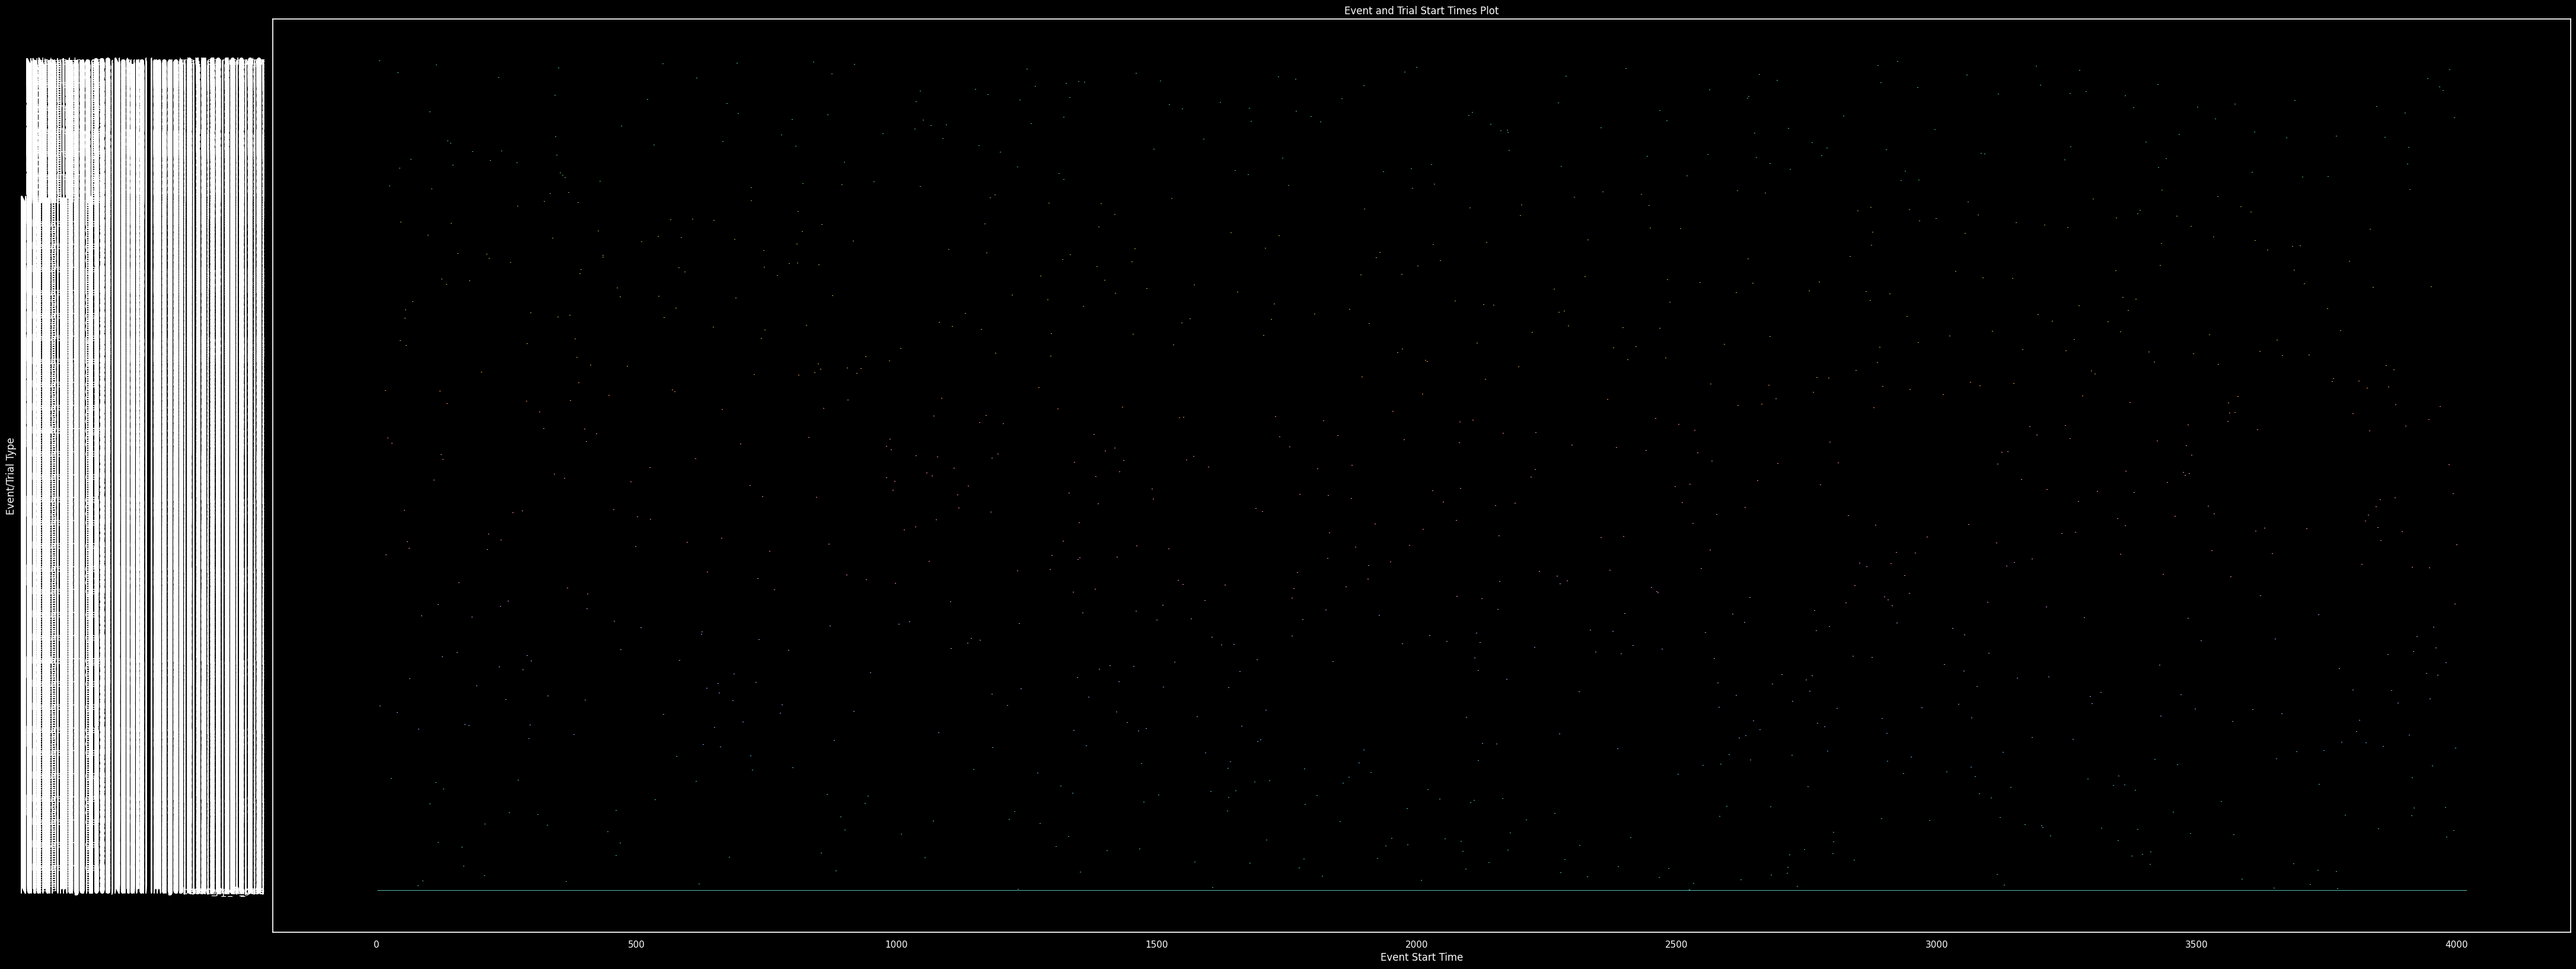

In [34]:
# Fetching data from the event.Event and trial.Trial tables
event_data = (event.Event & scan_key).fetch('event_type', 'event_start_time', as_dict=True)
trial_data = (trial.Trial & scan_key).fetch('trial_id', 'trial_type', 'trial_start_time', as_dict=True)

djh.plot_event_trial_start_times(event_data, trial_data)

### get BPOD object to play around

In [ ]:
from adamacs.paths import get_imaging_root_data_dir, get_experiment_root_data_dir
from adamacs.ingest import bpod
from element_interface.utils import find_full_path

scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
bpod_path_relative = (scan.ScanPath & scan_key).fetch("path")[0]

bpod_path_full = list(find_full_path(
        get_experiment_root_data_dir(), bpod_path_relative
        ).glob("*mat"))[0]

print(bpod_path_full)

In [ ]:
bpod_object = bpod.Bpodfile(bpod_path_full)

In [ ]:
bpod_object.session_data["Info"]

In [ ]:
bpod_object.session_data["MousePos"]['PreStimDLC_live'][10]['right_ear']

In [ ]:
bpod_object.session_data['RawEvents']['Trial'][4]['States']

In [ ]:
bpod_object.trial_data[4]['States']

In [ ]:
bpod_object.trial_data[3]['Events']

In [ ]:
trials = bpod_object.trial_data
SoftCode10_events = [(i, trial['Events'].get('SoftCode10')) for i, trial in enumerate(trials) if 'SoftCode10' in trial['Events']] # get all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)

SoftCode10_events_times = [x[1] for x in SoftCode10_events]

plt.hist(SoftCode10_events_times, edgecolor='black')

plt.title('Histogram of softcode 10 event-to-trial-beginning time')
plt.xlabel('[s]')
plt.ylabel('Frequency')
# plt.xlim([0, 1])
plt.show()

In [ ]:
trials = bpod_object.trial_data
SoftCode15_events = [(i, trial['Events'].get('SoftCode15')) for i, trial in enumerate(trials) if 'SoftCode15' in trial['Events']] # get all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)

SoftCode15_events_times = [x[1] for x in SoftCode15_events]

plt.hist(SoftCode15_events_times, edgecolor='black')

plt.title('Histogram of softcode 15 event-to-trial-beginning time')
plt.xlabel('[s]')
plt.ylabel('Frequency')
# plt.xlim([0, 100])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Fetch trial data
trials = bpod_object.trial_data

# Fetch trial start timestamps
bpod_trial = bpod_object.session_data["TrialStartTimestamp"]

WaitForPosTriggerSoftCode_events = [(trial['States'].get('WaitForPosTriggerSoftCode') if trial['States'].get('WaitForPosTriggerSoftCode') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'WaitForPosTriggerSoftCode' in trial['States']]
WaitForPosTriggerSoftCode = [event[1] for event in WaitForPosTriggerSoftCode_events]

CueDelayTrialCricket_events = [(trial['States'].get('CueDelayTrialCricket') if trial['States'].get('CueDelayTrialCricket') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'CueDelayTrialCricket' in trial['States']]
CueDelayTrialCricket = [event[0] for event in CueDelayTrialCricket_events]

CueDelay_events = [(trial['States'].get('CueDelay') if trial['States'].get('CueDelay') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'CueDelay' in trial['States']]
CueDelay  = [event[0] for event in CueDelay_events]

Drinking_events = [(trial['States'].get('Drinking') if trial['States'].get('Drinking') is not None else 0) + bpod_trial[i] for i, trial in enumerate(trials) if 'Drinking' in trial['States']]
DrinkingResponse = [event[0] for event in Drinking_events]


# Fetch all trials that have a BNC1Low event. Returns a list of tuples (trial number, event time)
BNC1Low_events = [(i, trial['Events'].get('BNC1Low')) for i, trial in enumerate(trials) if 'BNC1Low' in trial['Events']]

# Fetch shutter event start times
AUX_shutter = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%shutter%"').fetch("event_start_time")

# Fetch event start times for visual and tone events
aux_vis = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%vis%"').fetch("event_start_time") 
aux_tone = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%tone%"').fetch("event_start_time") 
aux_reward = (event.Event & 'scan_id = "' + scansi + '"' & 'event_type LIKE "%reward%"').fetch("event_start_time") 

# Adjust bpod_trial times

# bpodoffset = (BNC1Low_events[0][1]  + bpod_trial[0]) 

bpodoffset = (WaitForPosTriggerSoftCode[0]) 
aux_offset = aux_vis[0] 

WaitForPosTriggerSoftCode = WaitForPosTriggerSoftCode - bpodoffset + aux_offset
CueDelay = CueDelay - bpodoffset + aux_offset 
CueDelayTrialCricket = CueDelayTrialCricket - bpodoffset + aux_offset
DrinkingResponse = DrinkingResponse - bpodoffset + aux_offset
bpod_trial = bpod_trial - bpodoffset + aux_offset

# # Adjust AUX times
# aux_offset = aux_vis[0] 

# AUX_shutter = AUX_shutter - aux_offset #+  bpod_trial[1]
# aux_vis = aux_vis - aux_offset #+  bpod_trial[1]
# aux_tone    = aux_tone - aux_offset #+  bpod_trial[1]
# aux_reward = aux_reward - aux_offset #+  bpod_trial[1]


# Convert aux_tone, bpod_trial, and aux_vis values from seconds to deciseconds
tone_timestamps = (aux_tone * 100).astype(int)
trial_timestamps = (bpod_trial * 100).astype(int)
vis_timestamps = (aux_vis * 100).astype(int)
reward_timestamps = (aux_reward * 100).astype(int)
WaitForPosTriggerSoftCode_timestamps = (np.array(WaitForPosTriggerSoftCode) * 100).astype(int)
CueDelay_timestamps = (np.array(CueDelay) * 100).astype(int)
CueDelayTrialCricket_timestamps = (np.array(CueDelayTrialCricket) * 100).astype(int)
DrinkingResponse_timestamps = (np.array(DrinkingResponse) * 100).astype(int)

# Create separate timebases for each event type
timebase_tone = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_trial = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_vis = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_reward = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_WaitForPosTriggerSoftCode = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_CueDelay = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
timebase_CueDelayTrialCricket = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))
DrinkResponse = np.zeros(int(max(tone_timestamps.max(), trial_timestamps.max(), vis_timestamps.max(), reward_timestamps.max(), WaitForPosTriggerSoftCode_timestamps.max(), CueDelay_timestamps.max()) + 1))


# Set the timebase samples that correspond to the tone onsets, trial starts, and visual cue onsets to one
# Each event has a duration of 100ms
for timestamp in tone_timestamps:
    timebase_tone[timestamp:timestamp+1] = 2
for timestamp in trial_timestamps:
    timebase_trial[timestamp:timestamp+1] = 3
for timestamp in vis_timestamps:
    timebase_vis[timestamp:timestamp+1] = 1
for timestamp in reward_timestamps:
    timebase_reward[timestamp:timestamp+1] = 4
for timestamp in WaitForPosTriggerSoftCode_timestamps:
    timebase_WaitForPosTriggerSoftCode[timestamp:timestamp+1] = 5
for timestamp in CueDelay_timestamps:
    timebase_CueDelay[timestamp:timestamp+1] = 6
for timestamp in CueDelayTrialCricket_timestamps:
    timebase_CueDelayTrialCricket[timestamp:timestamp+1] = 7  
for timestamp in DrinkingResponse_timestamps:
    DrinkResponse[timestamp:timestamp+1] = 8   

# Set the style to 'dark_background'
plt.style.use('dark_background')

# Create a color palette
colors = sns.color_palette("husl", 8)

# Create a figure with a width that fits the screen
plt.figure(figsize=(50, 10))

# Create tick plots with colors from the palette
linelength = 0.7

plt.eventplot(np.where(timebase_tone == 2)[0], lineoffsets=1, colors=colors[0], linelengths=linelength, label='AUX Tone onsets')
plt.eventplot(np.where(timebase_vis == 1)[0], lineoffsets=2, colors=colors[1], linelengths=linelength, label='AUX Visual cue onsets')
plt.eventplot(np.where(timebase_reward == 4)[0], lineoffsets=3, colors=colors[2], linelengths=linelength, label='AUX Reward onsets')
plt.eventplot(np.where(timebase_trial == 3)[0], lineoffsets=4, colors=colors[3], linelengths=linelength, label='BPOD Trial starts')
plt.eventplot(np.where(timebase_WaitForPosTriggerSoftCode == 5)[0], lineoffsets=5, colors=colors[4], linelengths=linelength, label='WaitForPosTriggerSoftCode')
plt.eventplot(np.where(timebase_CueDelay == 6)[0], lineoffsets=6, colors=colors[5], linelengths=linelength, label='CueDelay')
plt.eventplot(np.where(timebase_CueDelayTrialCricket == 7)[0], lineoffsets=7, colors=colors[6], linelengths=linelength, label='CueDelayTrialCricket') 
plt.eventplot(np.where(DrinkResponse == 8)[0], lineoffsets=8, colors=colors[7], linelengths=linelength, label='DrinkingResponse')

plt.yticks([1, 2, 3, 4, 5, 6, 7, 8], ['AUX Tone onsets', 'AUX Visual cue_triggered', 'AUX Reward onsets', 'BPOD Trial starts', 'WaitForPosTriggerSoftCode', 'CueDelay', 'CueDelayTrialCricket', 'Drinking'])

# Draw vertical lines where timebase_trial == 3

for i in np.where(timebase_trial == 3)[0]:
    plt.axvline(x=i, color='w', linestyle='--', linewidth=0.5, zorder=0)

# Get the y-tick labels
labels = plt.gca().get_yticklabels()

# Find the labels to change
for label in labels:
    if label.get_text() == 'WaitForPosTriggerSoftCode' or label.get_text() == 'AUX Visual cue_triggered':
        label.set_color('red')
        label.set_fontweight('bold')
    if label.get_text() == 'BPOD Trial starts':
        label.set_color('green')
        label.set_fontweight('bold')


plt.legend()
plt.xlim([71000, 81500])
plt.show()

## Run image processing jobs


In [29]:
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}
imaging.Processing.populate(**populate_settings)

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

{'data_path': ['/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL'], 'tiff_list': ['/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-10-17_scan9FKMRSOL_sess9FKMRSOL/scan9FKMRSOL_LE_WEZ-8909_00001.tif']}
tif
** Found 1 tifs - converting to binary **
32000 frames of binary, time 171.56 sec.
64000 frames of binary, time 219.06 sec.
96000 frames of binary, time 272.23 sec.
time 315.01 sec. Wrote 120300 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying classifier /home/tobiasr/adamacs/user_data/s2p_classifiers/TR_HPC_bench2p_classifier.npy
----------- REGISTRATION
NOTE: estimated bidiphase offset from data: 0 pixels
Reference frame, 17.20 sec.
Registered 8000/120300 in 112.69s
Registered 16000/120300 in 228.48s
Registered 24000/120300 in 328.94s
Registered 32000/120300 in 429.19s
Registered 40000/120300 in 53

/home/tobiasr/miniconda3/envs/datajoint-DLCbackup/lib/python3.8/site-packages/scipy/io/matlab/_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


deleting binary files
Plane 0 processed in 2142.59 sec (can open in GUI).
total = 2463.53 sec.
TOTAL RUNTIME 2463.53 sec


Processing: 100%|██████████| 1/1 [41:03<00:00, 2463.55s/it]


### Curation

In [13]:
samesite = 'sess9FK61CPU'
key =  (session.SessionSameSite & f'same_site_id="{samesite}"').fetch('KEY')
scan.Scan & key

session_id,scan_id,scanner,acq_software,scan_notes free-notes
sess9FK5ZXM1,scan9FK5ZXM1,bench2p,ScanImage,none
sess9FK60H47,scan9FK60H47,bench2p,ScanImage,none
sess9FK60RLK,scan9FK60RLK,bench2p,ScanImage,none
sess9FK610VH,scan9FK610VH,bench2p,ScanImage,none
sess9FK618YH,scan9FK618YH,bench2p,ScanImage,none
sess9FK61CPU,scan9FK61CPU,bench2p,ScanImage,none
sess9FK61UDV,scan9FK61UDV,bench2p,ScanImage,none
sess9FK6245N,scan9FK6245N,bench2p,ScanImage,none
sess9FK629TR,scan9FK629TR,bench2p,ScanImage,none
sess9FK6KH4G,scan9FK6KH4G,bench2p,ScanImage,none


In [14]:
imaging.ProcessingTask()

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
sess9FK5ZXM1,scan9FK5ZXM1,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK5ZXM1_sess9FK5ZXM1,trigger
sess9FK60H47,scan9FK60H47,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK60H47_sess9FK60H47,trigger
sess9FK60RLK,scan9FK60RLK,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK60RLK_sess9FK60RLK,trigger
sess9FK610VH,scan9FK610VH,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK610VH_sess9FK610VH,trigger
sess9FK618YH,scan9FK618YH,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK618YH_sess9FK618YH,trigger
sess9FK61CPU,scan9FK61CPU,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK61CPU_sess9FK61CPU,trigger
sess9FK61UDV,scan9FK61UDV,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK61UDV_sess9FK61UDV,trigger
sess9FK6245N,scan9FK6245N,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK6245N_sess9FK6245N,trigger
sess9FK629TR,scan9FK629TR,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK629TR_sess9FK629TR,trigger
sess9FK6KH4G,scan9FK6KH4G,3,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-20_scan9FK6KH4G_sess9FK6KH4G,trigger


In [ ]:

populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}



### Creat a curation task for each entry in the imaging.Processing table

In [37]:
for processing_task in imaging.ProcessingTask():
    # Extract necessary information from processing_task
    # This depends on the structure of your Processing table
    # For example, you might need the session_id and scan_id
    session_id = processing_task['session_id']
    scan_id = processing_task['scan_id']
    imaging.Curation().create1_from_processing_task({'session_id': session_id, 'scan_id': scan_id, "paramset_idx": 3, "manual_curation": False})


In [40]:
 imaging.Curation()


session_id,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
sess9FK5ZXM1,scan9FK5ZXM1,3,1,2023-11-24 18:07:22,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK5ZXM1_sess9FK5ZXM1,0,
sess9FK60H47,scan9FK60H47,3,1,2023-11-24 18:29:35,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK60H47_sess9FK60H47,0,
sess9FK60RLK,scan9FK60RLK,3,1,2023-11-24 18:39:03,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK60RLK_sess9FK60RLK,0,
sess9FK610VH,scan9FK610VH,3,1,2023-11-24 18:48:13,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK610VH_sess9FK610VH,0,
sess9FK618YH,scan9FK618YH,3,1,2023-11-24 18:56:29,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK618YH_sess9FK618YH,0,
sess9FK61CPU,scan9FK61CPU,3,1,2023-11-24 19:00:40,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK61CPU_sess9FK61CPU,0,
sess9FK61UDV,scan9FK61UDV,3,1,2023-11-24 19:20:01,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK61UDV_sess9FK61UDV,0,
sess9FK6245N,scan9FK6245N,3,1,2023-11-24 19:29:08,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK6245N_sess9FK6245N,0,
sess9FK629TR,scan9FK629TR,3,1,2023-11-24 19:33:55,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-19_scan9FK629TR_sess9FK629TR,0,
sess9FK6KH4G,scan9FK6KH4G,3,1,2023-11-24 19:37:39,/datajoint-data/data/tobiasr/LE_WEZ-8909_2023-09-20_scan9FK6KH4G_sess9FK6KH4G,0,


In [ ]:
### run trace populations

In [9]:
selected_s2pparms_index = 3

# POPULATE!
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}

#imaging.Curation().create1_from_processing_task({'session_id': sessi, 'scan_id': scansi, "paramset_idx": selected_s2pparms_index, "manual_curation": 0})

imaging.MotionCorrection.populate(**populate_settings)

imaging.Segmentation.populate(**populate_settings)

imaging.MaskClassification.populate(**populate_settings)


MaskClassification: 100%|██████████| 1/1 [00:00<00:00, 1495.83it/s]


In [10]:

imaging.Fluorescence.populate(**populate_settings)


In [11]:
imaging.Activity.populate(**populate_settings)

In [12]:
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')

NameError: name 'scansi' is not defined

## Make Movie

In [ ]:
path = (scan.ScanPath & curation_key).fetch1("path") + ("/suite2p/plane0/reg_tif")
sh.make_runninaverage_movie(path)

## Pose estimation

In [ ]:
dj.Diagram(model) + dj.Diagram(equipment)

In [ ]:
model.Model()

In [ ]:
aux_setup_typestr = (scan.ScanInfo() & 'scan_id = "' + scansi + '"').fetch("userfunction_info")[0]
selected_DLCmodel = 'Topcam_2bin_without_scope'
print('- - - -')
print('DLC pose estimation:', scansi)

# insert TOP movie into model table
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
    'recording_id': scan_key["scan_id"], 
    'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
    }
model.VideoRecording.insert1(key, skip_duplicates=True)

key.update({'file_path': moviepath,
            'file_id': 0})  #INCREMENT FILE_ID WITH CAM NUMBER?

model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)
model.RecordingInfo.populate()

In [ ]:

model.VideoRecording.File * model.VideoRecording() &  'recording_id = "' + scansi + '"'

In [ ]:
key =  (model.VideoRecording & f'recording_id="{scansi}"').fetch1('KEY')
key.update({'model_name': selected_DLCmodel, 'task_mode': 'trigger'}) 
key      


In [ ]:
# INSERT pose estimation task
model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True, 'dynamic':(True,.5,60)}) # dynamic cropping

In [ ]:
model.PoseEstimationTask() * model.VideoRecording * model.VideoRecording.File()

In [ ]:
model.RecordingInfo()

In [ ]:
# run pose estimation
model.PoseEstimation.populate()

#### make labeled video

In [ ]:
from deeplabcut.utils.make_labeled_video import create_labeled_video
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir


destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)

# list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))

In [ ]:
import glob
mp4_files = glob.glob(f"{destfolder}/*.mp4")
mp4_files[0]

In [ ]:
(model.PoseEstimation() * session.Session * session.SessionUser * subject.User()).fetch(format = "frame", order_by = "session_datetime")

In [ ]:
# scansi = "scan9FKSMYYS"
scan_key = (model.PoseEstimation & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

In [ ]:
(model.PoseEstimation.BodyPartPosition() & scan_key & 'body_part = "head_middle"').fetch("x_pos", "y_pos")

## Cleaning. Use with caution!

In [ ]:
imaging.ProcessingTask()

In [ ]:
scan_key

In [ ]:
# subject.Subject.delete()
# session.Session.delete()
# imaging.Processing.delete()
# imaging.Curation.delete()
# event.Event.delete()
# event.BehaviorRecording.delete()

In [ ]:
# key = (session.Session & "session_datetime >= '2023-10-01'").fetch('KEY')
# (session.Session & "session_datetime >= '2023-10-01'").delete()
# (imaging.ProcessingTask & "session_id LIKE 'sess9FKWT2RT%'").delete()
# (imaging.ProcessingTask  & key).delete()
# (model.PoseEstimationTask & key).delete()
(session.Session & "session_id LIKE '%sess9FK610VH%'").delete()
# (subject.Subject & "subject = 'ROS-1571'").delete()
# # subject.Subject.delete()
# # session.Session.delete()
# # imaging.Processing.delete()
# # imaging.Curation.delete()
# # event.Event.delete()
# # event.BehaviorRecording.delete()

In [ ]:
session.Session.delete()

In [ ]:
# session.Session.drop()
# scan.Scan.drop()
# imaging.Processing.drop()
# imaging.Curation.drop()